In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# valid intervals - 1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 6h, 8h, 12h, 1d, 3d, 1w, 1M
interval = '1m'
# USDT base
#pairs = ['BTCUSDT', 'ETHUSDT','ADAUSDT','CHZUSDT','ENJUSDT','LINKUSDT','FILUSDT','XRPUSDT', 'DOTUSDT']
# BTC base
pairs = ['ETHBTC','ADABTC','CHZBTC','ENJBTC','LINKBTC','FILBTC','XRPBTC', 'DOTBTC']
#recomendations from Fausto Botelho in 29/07/2021 (https://www.youtube.com/channel/UCFzEG7N47dktszRxdfOHJdA)
#pairs = ['BATBTC', 'BNBBTC', 'CHZBTC', 'ETHBTC', 'KNCBTC', 'MATICBTC', 'XEMBTC', 'ONTBTC', 
#    'CAKEBTC', 'RENBTC', 'XRPBTC', 'SOLBTC', 'STEEMBTC', 'SUSHIBTC', 'TRXBTC', 'UNIBTC']
#pairs = ['EGLDBTC', 'FETBTC', 'SKLBTC', 'KAVABTC', 'SXPBTC']

# date to start/end analysis
dt_start_analysis = '2021-1-1'
# Use '' for analysis until now
dt_end_analysis = ''

In [3]:
from trade_utils import initialize_ohlc_df
from binance_utils import update_historical_data, init

client = init()

crypto_pairs_dict = {}

for pair in pairs:
    try:
        df = pd.read_csv('data/' + pair + '-' + interval + '-binance-all.csv')
        df['OpenTime'] = pd.to_datetime(df['OpenTime'])
        df.set_index('OpenTime', inplace=True)
    except FileNotFoundError:
        df = initialize_ohlc_df()
    
    df = update_historical_data(client, df, pair, interval)

    filename = 'data/' + pair + '-' + interval + '-binance-all.csv'
    df.to_csv(filename)

    if dt_end_analysis == '':
        crypto_pairs_dict[pair] = df[dt_start_analysis:]
    else:
        crypto_pairs_dict[pair] = df[dt_start_analysis:dt_end_analysis]

In [4]:
# Example
pair = pairs[0]

crypto_pairs_dict[pair].tail()

,OpenPrice,HighPrice,LowPrice,ClosePrice,Volume
OpenTime,,,,,
2021-08-13 11:59:00,0.069759,0.069759,0.069644,0.069650,106.707
2021-08-13 12:00:00,0.069646,0.069728,0.069646,0.069697,98.806
2021-08-13 12:01:00,0.069705,0.069705,0.069670,0.069690,151.463
2021-08-13 12:02:00,0.069695,0.069716,0.069680,0.069714,87.974
2021-08-13 12:03:00,0.069712,0.069715,0.069660,0.069703,91.615


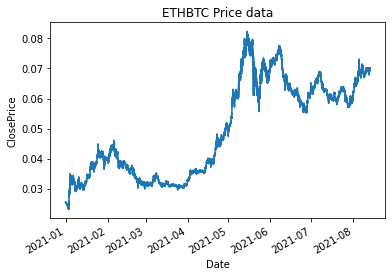

In [5]:
crypto_pairs_dict[pair]['ClosePrice'].plot()
plt.xlabel('Date')
plt.ylabel('ClosePrice')
plt.title(pair + " Price data")
plt.show()

In [6]:
daily_returns = crypto_pairs_dict[pair]['ClosePrice'].resample('1d').ffill().pct_change()
monthly_returns = crypto_pairs_dict[pair]['ClosePrice'].resample('M').ffill().pct_change()

In [7]:
daily_returns.head()

OpenTime
2021-01-01         NaN
2021-01-02   -0.022712
2021-01-03   -0.032648
2021-01-04    0.237624
2021-01-05    0.099510
Freq: D, Name: ClosePrice, dtype: float64

In [8]:
monthly_returns.head()

OpenTime
2021-01-31         NaN
2021-02-28   -0.214816
2021-03-31   -0.007942
2021-04-30    0.642768
2021-05-31    0.296492
Freq: M, Name: ClosePrice, dtype: float64

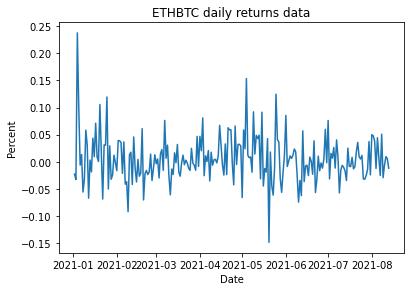

In [9]:
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.plot(daily_returns)
ax1.set_xlabel("Date")
ax1.set_ylabel("Percent")
ax1.set_title(pair + " daily returns data")
plt.show()

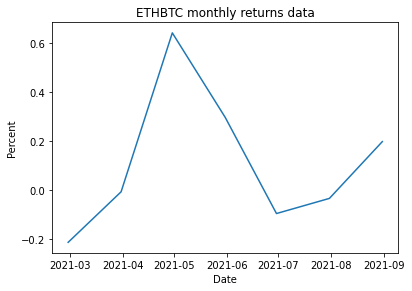

In [10]:
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.plot(monthly_returns)
ax1.set_xlabel("Date")
ax1.set_ylabel("Percent")
ax1.set_title(pair + " monthly returns data")
plt.show()

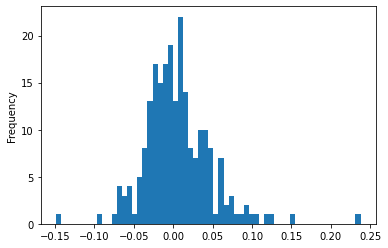

In [11]:
fig = plt.figure()
#ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
daily_returns.plot.hist(bins = 60)
ax1.set_xlabel("Daily returns %")
ax1.set_ylabel("Percent")
ax1.set_title(pair + " daily returns data")
plt.show()

In [12]:
cum_returns = (daily_returns + 1).cumprod()

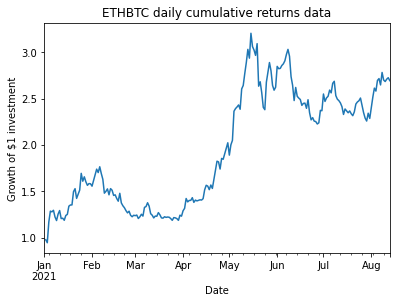

In [13]:
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
cum_returns.plot()
ax1.set_xlabel("Date")
ax1.set_ylabel("Growth of $1 investment")
ax1.set_title(pair + " daily cumulative returns data")
plt.show()

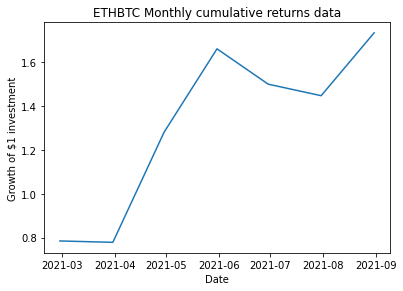

In [14]:
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
cum_returns = (monthly_returns + 1).cumprod()
ax1.plot(cum_returns)
ax1.set_xlabel("Date")
ax1.set_ylabel("Growth of $1 investment")
ax1.set_title(pair + " Monthly cumulative returns data")
plt.show()

<Figure size 432x288 with 0 Axes>

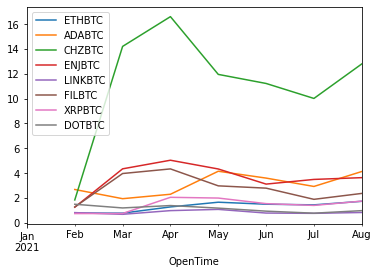

In [15]:
multpl_crypto_daily_returns = pd.DataFrame()
multpl_crypto_monthly_returns = pd.DataFrame()

for pair in pairs:
    multpl_crypto_daily_returns[pair] = crypto_pairs_dict[pair]['ClosePrice'].pct_change()
    multpl_crypto_monthly_returns[pair] = crypto_pairs_dict[pair]['ClosePrice'].resample('M').ffill().pct_change()

fig = plt.figure()
(multpl_crypto_monthly_returns + 1).cumprod().plot()
plt.show()

In [16]:
print(multpl_crypto_monthly_returns.mean())

ETHBTC     0.111752
ADABTC     0.355371
CHZBTC     1.079163
ENJBTC     0.373852
LINKBTC   -0.003228
FILBTC     0.290409
XRPBTC     0.198082
DOTBTC     0.027292
dtype: float64


In [17]:
print(multpl_crypto_monthly_returns.std())

ETHBTC     0.291410
ADABTC     0.698777
CHZBTC     2.511736
ENJBTC     0.938073
LINKBTC    0.238979
FILBTC     0.838428
XRPBTC     0.696557
DOTBTC     0.279609
dtype: float64


In [18]:
print(multpl_crypto_monthly_returns.corr())

           ETHBTC    ADABTC    CHZBTC    ENJBTC   LINKBTC    FILBTC    XRPBTC  \
ETHBTC   1.000000 -0.147172 -0.225053 -0.167694  0.949924 -0.183644  0.885560   
ADABTC  -0.147172  1.000000 -0.301503 -0.312612 -0.006040 -0.257123 -0.165845   
CHZBTC  -0.225053 -0.301503  1.000000  0.989901 -0.321691  0.983072 -0.118273   
ENJBTC  -0.167694 -0.312612  0.989901  1.000000 -0.235414  0.964127 -0.054467   
LINKBTC  0.949924 -0.006040 -0.321691 -0.235414  1.000000 -0.280469  0.885873   
FILBTC  -0.183644 -0.257123  0.983072  0.964127 -0.280469  1.000000 -0.048923   
XRPBTC   0.885560 -0.165845 -0.118273 -0.054467  0.885873 -0.048923  1.000000   
DOTBTC   0.023348  0.765266 -0.225915 -0.215858  0.214234 -0.100247  0.208174   

           DOTBTC  
ETHBTC   0.023348  
ADABTC   0.765266  
CHZBTC  -0.225915  
ENJBTC  -0.215858  
LINKBTC  0.214234  
FILBTC  -0.100247  
XRPBTC   0.208174  
DOTBTC   1.000000  


In [19]:
print(multpl_crypto_monthly_returns.cov())

           ETHBTC    ADABTC    CHZBTC    ENJBTC   LINKBTC    FILBTC    XRPBTC  \
ETHBTC   0.084920 -0.029969 -0.164726 -0.045841  0.066154 -0.044869  0.179754   
ADABTC  -0.029969  0.488289 -0.529180 -0.204918 -0.001009 -0.150642 -0.080723   
CHZBTC  -0.164726 -0.529180  6.308815  2.332397 -0.193096  2.070262 -0.206926   
ENJBTC  -0.045841 -0.204918  2.332397  0.879981 -0.052775  0.758293 -0.035590   
LINKBTC  0.066154 -0.001009 -0.193096 -0.052775  0.057111 -0.056197  0.147465   
FILBTC  -0.044869 -0.150642  2.070262  0.758293 -0.056197  0.702962 -0.028571   
XRPBTC   0.179754 -0.080723 -0.206926 -0.035590  0.147465 -0.028571  0.485191   
DOTBTC   0.001902  0.149521 -0.158661 -0.056618  0.014315 -0.023501  0.040545   

           DOTBTC  
ETHBTC   0.001902  
ADABTC   0.149521  
CHZBTC  -0.158661  
ENJBTC  -0.056618  
LINKBTC  0.014315  
FILBTC  -0.023501  
XRPBTC   0.040545  
DOTBTC   0.078181  
